# Import and Seed

In [ ]:
import os
import glob
import sys
import zipfile
import shutil

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import torch.utils.model_zoo as model_zoo
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader, Dataset

import cv2
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix


In [ ]:
# Unmount so doesn't throw "Transport endpoint not connected:" error
!fusermount -u /gdrive

fusermount: failed to unmount /gdrive: No such file or directory


In [ ]:
# MOUNTING GOOGLE DRIVE WHERE DATA IS STORED
from google.colab import drive
drive.mount('/gdrive/', force_remount=True)

Mounted at /gdrive/


In [ ]:
%cd /gdrive/MyDrive/BMEN4460 DL in BMI Final Project/Model Weights/

/gdrive/MyDrive/BMEN4460 DL in BMI Final Project/Model Weights


In [ ]:
cuda = torch.cuda.is_available()
print("GPU available:", cuda)

GPU available: True


In [ ]:
torch.manual_seed(4460)
np.random.seed(4460)

# Data Exploration (Scrap)

In [ ]:
# # this is scrap code where i see how everything works
# data_root_folder = '/gdrive/My Drive/BMEN4460 DL in BMI Final Project/DL_data/'
# folder = os.path.join(data_root_folder, 'Train')
# imgs_dir = os.path.join(folder, 'PairedData')
# imgs_file_tuple = sorted(glob.glob(os.path.join(imgs_dir, '*.npy')))
# imgs_file_tuple


In [ ]:
# file = np.load('/gdrive/My Drive/BMEN4460 DL in BMI Final Project/DL_data/Train/PairedData/Train_pairs_0001.npy',allow_pickle=True)

In [ ]:
# imgs_file
# pair.shape
# slices, img/mask, pixel h, pixel w

In [ ]:
# from google.colab.patches import cv2_imshow
# plt.imshow(imgs[0,0,:,:])

In [ ]:
# imgs_file

In [ ]:
# tsst = np.load(imgs_file_tuple[0])
# tsst.shape

# Data Loader Preparation

In [ ]:
data_root_folder = '/gdrive/My Drive/BMEN4460 DL in BMI Final Project/DL_data/'

class BasicDataset(TensorDataset):
  # This function takes folder name ('train', 'valid', 'test') as input and creates an instance of BasicDataset according to that folder.
  # Also if you'd like to have less number of samples (for evaluation purposes), you may set the `n_sample` with an integer.
  def __init__(self, folder, n_sample=None):
    self.folder = os.path.join(data_root_folder, folder, 'PairedData')
    
    self.pairs_file = sorted(glob.glob(os.path.join(self.folder, '*.npy')))

    # If n_sample is not None (It has been set by the user)
    if not n_sample or n_sample > len(self.pairs_file):
        n_sample = len(self.pairs_file)

    self.n_sample = n_sample
    self.pairs_file = list([file_path for file_path in self.pairs_file[:n_sample]])
      
  # This function returns the lenght of the dataset (AKA number of samples in that set)
  def __len__(self):
    return len(self.pairs_file)

  def __getitem__(self, i):
    file_path = self.pairs_file[i]
    idx = os.path.basename(file_path)

    data = np.load(file_path, allow_pickle=True)
    
    img = data[0,:,:]
    mask = data[1,:,:]

    # #Resize all images from 512 to 256 (H and W) ################################### Important Note: Remove the following lines to go back to the original resolution (512x512)
    # img = cv2.resize(img, (256,256))
    # mask = cv2.resize(mask, (256,256))



    # Add channel axis
    img = np.expand_dims(img, axis=0)
    mask = np.expand_dims(mask, axis=0)

    return {
        'image': torch.from_numpy(img).type(torch.FloatTensor),
        'mask': torch.from_numpy(mask).type(torch.FloatTensor),
        'img_id': idx
    }

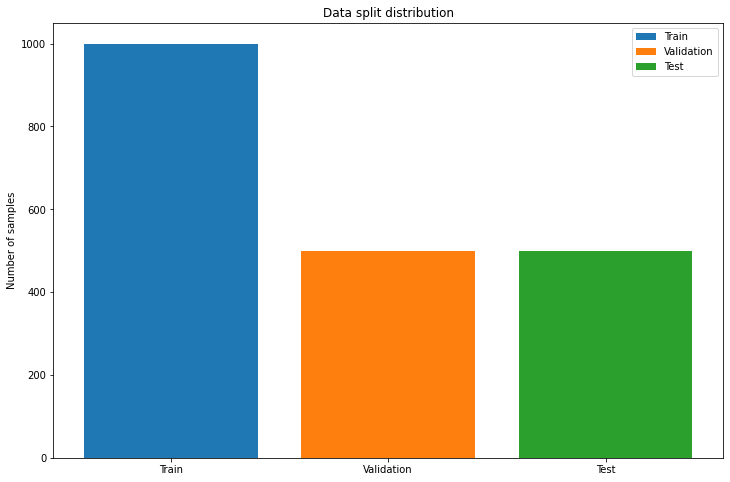

In [ ]:
# Create train, validation, and test dataset instances
train_dataset = BasicDataset('Train', n_sample=1000) #n_sample= 1000
valid_dataset = BasicDataset('Validation', n_sample=500)
test_dataset = BasicDataset('Test', n_sample=500)

plt.figure(figsize=(12,8))
plt.title('Data split distribution')
plt.bar(0, len(train_dataset), label='Train')
plt.bar(1, len(valid_dataset), label='Validation')
plt.bar(2, len(test_dataset), label='Test')
plt.ylabel('Number of samples')
plt.xticks([0,1,2],['Train', 'Validation', 'Test'])
plt.legend()
plt.show()

In [ ]:
print (len(train_dataset))
print (len(valid_dataset))
print (len(test_dataset))

1000
500
500


torch.Size([1, 512, 512])
x shape is torch.Size([1, 512, 512])
y shape is torch.Size([1, 512, 512])


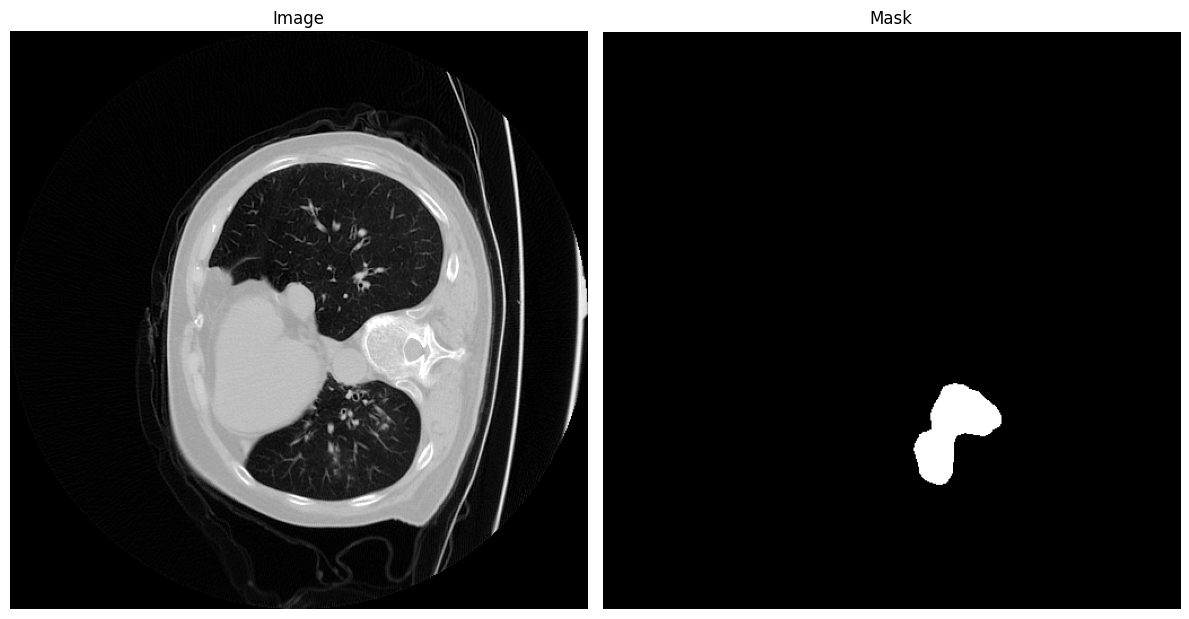

In [ ]:
# check if BasicDataset implementation works by pulling out a random sample of the training set
sample = np.random.randint(0, len(train_dataset))
data = train_dataset[sample]
print(data['image'].shape)
x = data['image']
y = data['mask']
idx = data['img_id']

print(f'x shape is {x.shape}')
print(f'y shape is {y.shape}')

plt.figure(figsize=(12, 8), dpi=100)
# plt.suptitle(f'Sample {idx:04d}')
img = np.squeeze(np.transpose(x, (1,2,0)))
mask = y[0]
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# create dataloaders

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# Print the shapes of the images and masks

for batch in train_dataloader:
    sample_batch = batch
    break

print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\n'.format(sample_batch['image'].shape, 
                                                                                           sample_batch['mask'].shape))


Sample batch 'image 'shape is: torch.Size([1, 1, 512, 512])
Sample batch 'mask' shape is: torch.Size([1, 1, 512, 512])



Building Blocks for U-Net

In [ ]:
######################################## Double Convolution
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

    
######################################## Maxpooling followed by Double Convolution
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


######################################## Upsampling followed by Double Convolution
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
        ) 
        self.conv = DoubleConv(out_channels * 2, out_channels)


    def forward(self, x1, x2):
        x1 = self.up_conv(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        return x

######################################## Output layer (1x1 Convolution followed by SoftMax activation)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv_sigmoid = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv_sigmoid(x)

# Segmentation 1: U-Net

## Model Building

In [ ]:
class UNet(nn.Module):
    def __init__(self, name, n_channels, n_classes):
        super(UNet, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inputL = DoubleConv(n_channels, 64) #16, lower
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outputL = OutConv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inputL(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        b = self.down4(x4)
        
        x = self.up1(b, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        x = self.outputL(x)
        
        return x

In [ ]:
# Define a function that computes the DICE score for binary segmentation
def dice_coeff_binary(y_pred, y_true):
        """Values must be only zero or one."""
        eps = 0.0001
        inter = torch.dot(y_pred.view(-1).float(), y_true.view(-1))
        union = torch.sum(y_pred) + torch.sum(y_true)
        return ((2 * inter.float() + eps) / (union.float() + eps)).cpu().numpy()
    

# The training function
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    if not os.path.isdir('{0}'.format(net.name)):
        os.mkdir('{0}'.format(net.name))
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    valid_loss = list()
    train_dice = list()
    valid_dice = list()
    
    for epoch in range(epochs):
        
        ################################################################################################################################
        ########################################################### Training ###########################################################
        ################################################################################################################################
        net.train()
        train_batch_loss = list()
        train_batch_dice = list()
        
        for i, batch in enumerate(train_dataloader):

            # Load a batch and pass it to the GPU
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()

            # Produce the estimated mask using current weights
            y_pred = net(imgs)

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            train_batch_loss.append(batch_loss)

            # Make the thresholded mask to compute the DICE score
            pred_binary = (y_pred > 0.5).float()                    # You can change the probablity threshold!
            
            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            train_batch_dice.append(batch_dice_score)
            

            # Reset gradient values
            optimizer.zero_grad()

            # Compute the backward losses
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # Print the progress
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, DICE score: {batch_dice_score}', end='\r')
        
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_dice = np.array(train_batch_dice).mean()
        train_loss.append(average_training_loss)
        train_dice.append(average_training_dice)
        
        ################################################################################################################################
        ########################################################## Validation ##########################################################
        ################################################################################################################################
        
        net.eval()
        valid_batch_loss = list()
        valid_batch_dice = list()
        
        # This part is almost the same as training with the difference that we will set all layers to evaluation mode (effects some layers such as BN and Dropout) and also
        # we don't need to calculate the gradient since we are only evaluating current state of the model. This will speed up the process and cause it to consume less memory.
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                # Load a batch and pass it to the GPU
                imgs = batch['image'].cuda()
                true_masks = batch['mask'].cuda()

                # Produce the estimated mask using current weights
                y_pred = net(imgs)

                # Compute the loss for this batch and append it to the epoch loss
                loss = loss_function(y_pred, true_masks)
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)

                # Make the thresholded mask to compute the DICE score
                pred_binary = (y_pred > 0.5).float()                    # You can change the probablity threshold!

                # Compute the DICE score for this batch and append it to the epoch dice
                batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
                valid_batch_dice.append(batch_dice_score)

                # Print the progress
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, DICE score: {batch_dice_score}', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_dice = np.array(valid_batch_dice).mean()
        valid_loss.append(average_validation_loss)
        valid_dice.append(average_validation_dice)
        
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training DICE score: {average_training_dice}, Validation Loss: {average_validation_loss}, Validation DICE score: {average_validation_dice}')

        ################################################################################################################################
        ###################################################### Saveing Checkpoints #####################################################
        ################################################################################################################################
        torch.save(net.state_dict(), f'{net.name}/epoch_{epoch+1:03}.pth')
    
    return train_loss, train_dice, valid_loss, valid_dice

## Training

In [ ]:
basic_UNet = UNet('BasicUNet', 1, 1)
# basic_UNet.cuda()

In [ ]:
# Create an instance of the optimizer and loss functions
optimizer = torch.optim.Adam(basic_UNet.parameters(), lr=0.001)
loss_function = nn.BCELoss()

In [ ]:
EPOCHS = 10
# train_loss, train_dice, valid_loss, valid_dice = train_net(basic_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_function)

## Results

Train/Validation

In [ ]:
plt.plot(range(EPOCHS),train_loss,label='Train')
plt.plot(range(EPOCHS),valid_loss,label='Validation')
plt.title('U-Net Loss Plot')
plt.legend()
plt.show

In [ ]:
plt.plot(range(EPOCHS),train_dice,label='Train')
plt.plot(range(EPOCHS),valid_dice,label='Validation')
plt.title('U-Net Dice Plot')
plt.legend()
plt.show

In [ ]:
# [1]*10**10 # use this to intentionally crash runtime and unallocate GPU memory for next model

In [ ]:
# best_epoch = np.argmax(valid_dice) + 1 # The plus one is because the epochs starts at 1.
best_epoch = 8 # NO NEED TO RETRAIN -- from output: "Best epoch is epoch8"
print(f'Best epoch is epoch{best_epoch}')

state_dict = torch.load(f'./BasicUNet/epoch_{best_epoch:03}.pth')

basic_UNet.load_state_dict(state_dict)
# basic_UNet.cuda()

Test

In [ ]:
# Take the first batch and test, see output
for batch in test_dataloader:
    sample_batch = batch
    break
    
# Generate network prediction
with torch.no_grad():
    y_pred = basic_UNet(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\nPredicted mask shape is: {2}'.format(sample_batch['image'].shape, 
                                                                                                                       sample_batch['mask'].shape,
                                                                                                                       y_pred.shape
                                                                                                                      ))

# Convert Pytorch tensor to numpy array then reverse the preprocessing steps
img = np.squeeze((sample_batch['image'][0].numpy().transpose(1,2,0) * 255).astype('uint8'))
msk = np.squeeze((sample_batch['mask'][0][0,:,:].numpy() * 255).astype('uint8'))

# Exctract the relative prediction mask and threshold the probablities (>0.5)
pred_msk = (y_pred.cpu().numpy()[0][0,:,:] * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

# Plot the smaple, ground truth, the prediction probability map, and the final predicted mask
plt.figure(figsize=(24,8))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(1,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title('Final Network Prediction Output \n(probability [0, 1])', fontsize=15)
plt.imshow(pred_msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.title('Final Thresholdded Binary Prediction (threshold > 0.5)', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

# input_overlayed_GT = img.copy()
# # input_overlayed_GT[msk==512, :] = [0, 512, 0]
# plt.subplot(2,4,5)
# plt.title('Input Image overlayed with Ground Truth', fontsize=15)
# plt.imshow(input_overlayed_GT)
# plt.axis('off')

# input_overlayed_Pred = img.copy()
# # input_overlayed_Pred[pred_msk_binary == 512, :] = [512, 0, 0]
# plt.subplot(2,4,6)
# plt.title('Input Image overlayed with Prediction', fontsize=15)
# plt.imshow(input_overlayed_Pred)
# plt.axis('off')

# GT_overlayed_prediction = np.zeros_like(img)
# # GT_overlayed_prediction[msk == 512, 1] = 512
# # GT_overlayed_prediction[pred_msk_binary == 512, 0] = 512
# plt.subplot(2,4,7)
# plt.title('Ground Truth overlayed with Prediction', fontsize=15)
# plt.imshow(GT_overlayed_prediction)
# plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Test function

def test_net(net, test_dataloader, loss_function):
    # Create the pred_mask folder
    if not os.path.isdir('/gdrive/My Drive/BMEN4460 DL in BMI Final Project/DL_data/predmask'):
        os.mkdir('/gdrive/My Drive/BMEN4460 DL in BMI Final Project/DL_data/predmask')
    
    net.eval()
    
    n_test = len(test_dataloader)
    test_batch_loss = list()
    test_batch_dice = list()
    test_batch_accuray = list()
    test_batch_CM = list()

    # This part is almost the same as the validation loop in `train_net` function. 
    # The difference is that we will calculate the accuracy and confusion matrix per each batch and save the predicted images.
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):

            # # Load a batch and pass it to the GPU
            imgs = batch['image']#.cuda()
            true_masks = batch['mask']#.cuda()
            img_ids = batch['img_id'] #.numpy().int()

            # Produce the estimated mask using current weights
            y_pred = net(imgs)

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            test_batch_loss.append(batch_loss)

            # Make the binary mask to compute the DICE score. Since the y_pred is a Pytoch tensor, we use `torch.argmax()` instead of `np.argmax()`.
            # the axis must be 1 instead of 0 because the format is [batch, channel, height, width]
            pred_binary = torch.argmax(y_pred, axis=1)

            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            test_batch_dice.append(batch_dice_score)
            
            # Save the predicted masks
            for idx, pred_msk in enumerate(pred_binary):
                cv2.imwrite(f'/gdrive/My Drive/BMEN4460 DL in BMI Final Project/DL_data/pred_mask_{img_ids[idx]}.png', pred_msk.cpu().numpy()) #{img_ids[idx]:04}.png
            
            # Vectorize the true mask and predicted mask for this batch
            vectorize_true_masks = true_masks.view(-1).cpu().numpy()
            vectorize_pred_masks = pred_binary.view(-1).cpu().numpy()
            
            # Compute the accuracy for this batch and append to the overall list
            batch_accuracy = accuracy_score(vectorize_true_masks, vectorize_pred_masks)
            test_batch_accuray.append(batch_accuracy)
            
            # Compute the normalized confusion matrix for this batch and append to the overall list
            batch_CM = confusion_matrix(vectorize_true_masks, vectorize_pred_masks, normalize='true', labels=[0, 1])
            test_batch_CM.append(batch_CM)

            # Print the progress
            print(f'Test Batch {i+1}/{n_test} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Accuracy: {batch_accuracy}', end='\r') # Jaccard score: {batch_jaccard_score}, 

    test_loss = np.array(test_batch_loss).mean()
    test_dice = np.array(test_batch_dice).mean()
    test_accuracy = np.array(test_batch_accuray).mean()
    test_CM = np.array(test_batch_CM).mean(axis=0)
    
    return test_loss, test_dice, test_accuracy, test_CM

In [ ]:
test_loss, test_dice, test_accuracy, test_CM = test_net(basic_UNet, test_dataloader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test overall accuracy: {test_accuracy}') # Test Jaccard score: {test_jaccard}, 

In [ ]:
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2]);
plt.ylabel('True labels');
plt.xlabel('predicted labels');

# Segmentation 2: U-Net with fewer layers

## Model Building

In [ ]:
class LiteUNet(nn.Module):
    def __init__(self, name, n_channels, n_classes):
        super(LiteUNet, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inputL = DoubleConv(n_channels, 64) 
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.up1 = Up(256, 128)
        self.up2 = Up(128, 64)
        self.outputL = OutConv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inputL(x)    
        x2 = self.down1(x1)
        
        b = self.down2(x2)
        
        x = self.up1(b, x2)
        x = self.up2(x, x1)
        
        x = self.outputL(x)
        
        return x

## Training

In [ ]:
lite_UNet = LiteUNet('LiteUNet', 1, 1)
lite_UNet.cuda()

LiteUNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05,

In [ ]:
# Create an instance of the optimizer and loss functions
optimizer = torch.optim.Adam(lite_UNet.parameters(), lr=0.001)
loss_function = nn.BCELoss()

In [ ]:
EPOCHS = 25
# train_loss, train_dice, valid_loss, valid_dice = train_net(lite_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_function)

## Results

Train/Validation

In [ ]:
plt.plot(range(EPOCHS),train_loss,label='Train')
plt.plot(range(EPOCHS),valid_loss,label='Validation')
plt.title('U-Net Loss Plot')
plt.legend()
plt.show

NameError: ignored

In [ ]:
plt.plot(range(EPOCHS),train_dice,label='Train')
plt.plot(range(EPOCHS),valid_dice,label='Validation')
plt.title('U-Net Dice Plot')
plt.legend()
plt.show

NameError: ignored

In [ ]:
# [1]*10**10 # use this to intentionally crash runtime and unallocate GPU memory for next model

In [ ]:
# best_epoch = np.argmax(valid_dice) + 1 # The plus one is because the epochs starts at 1.
best_epoch = 6 # from output: Best epoch is epoch6
print(f'Best epoch is epoch{best_epoch}')

state_dict = torch.load(f'./LiteUNet/epoch_{best_epoch:03}.pth')

lite_UNet.load_state_dict(state_dict)
lite_UNet.cuda()

Best epoch is epoch6


LiteUNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05,

Test

Sample batch 'image 'shape is: torch.Size([1, 1, 512, 512])
Sample batch 'mask' shape is: torch.Size([1, 1, 512, 512])
Predicted mask shape is: torch.Size([1, 1, 512, 512])


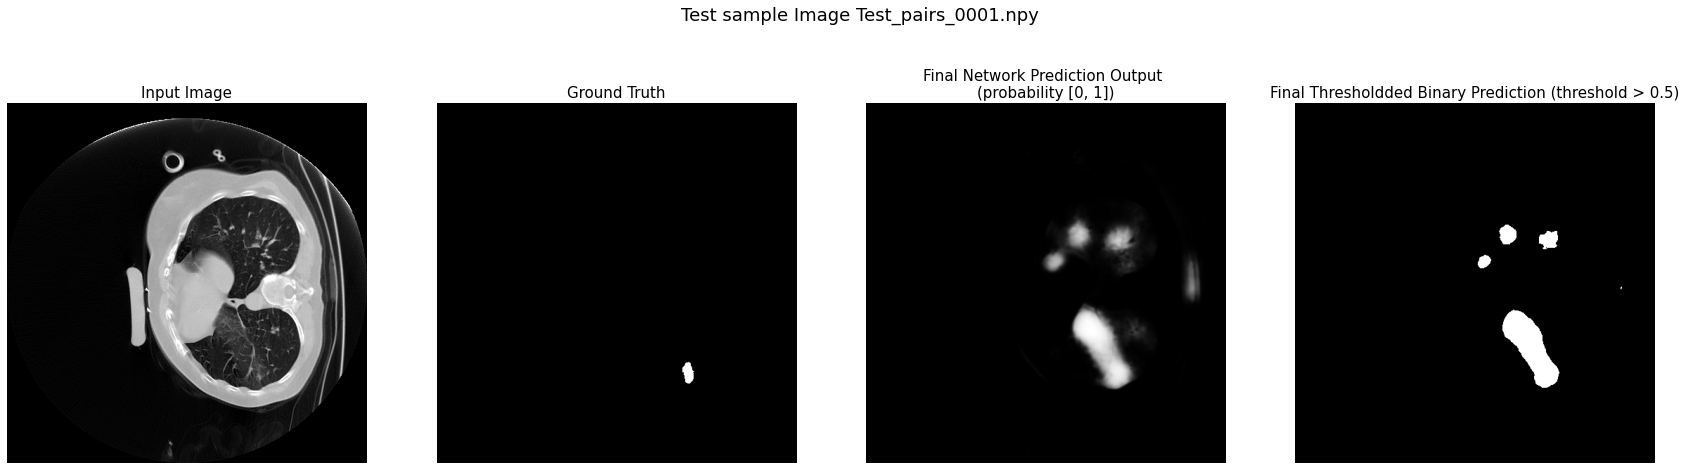

In [ ]:
# Take the first batch and test, see output
for batch in test_dataloader:
    sample_batch = batch
    break
    
# Generate network prediction
with torch.no_grad():
    y_pred = lite_UNet(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\nPredicted mask shape is: {2}'.format(sample_batch['image'].shape, 
                                                                                                                       sample_batch['mask'].shape,
                                                                                                                       y_pred.shape
                                                                                                                      ))

# Convert Pytorch tensor to numpy array then reverse the preprocessing steps
img = np.squeeze((sample_batch['image'][0].numpy().transpose(1,2,0) * 255).astype('uint8'))
msk = np.squeeze((sample_batch['mask'][0][0,:,:].numpy() * 255).astype('uint8'))

# Exctract the relative prediction mask and threshold the probablities (>0.5)
pred_msk = (y_pred.cpu().numpy()[0][0,:,:] * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

# Plot the smaple, ground truth, the prediction probability map, and the final predicted mask
plt.figure(figsize=(24,8))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(1,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title('Final Network Prediction Output \n(probability [0, 1])', fontsize=15)
plt.imshow(pred_msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.title('Final Thresholdded Binary Prediction (threshold > 0.5)', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

# input_overlayed_GT = img.copy()
# # input_overlayed_GT[msk==512, :] = [0, 512, 0]
# plt.subplot(2,4,5)
# plt.title('Input Image overlayed with Ground Truth', fontsize=15)
# plt.imshow(input_overlayed_GT)
# plt.axis('off')

# input_overlayed_Pred = img.copy()
# # input_overlayed_Pred[pred_msk_binary == 512, :] = [512, 0, 0]
# plt.subplot(2,4,6)
# plt.title('Input Image overlayed with Prediction', fontsize=15)
# plt.imshow(input_overlayed_Pred)
# plt.axis('off')

# GT_overlayed_prediction = np.zeros_like(img)
# # GT_overlayed_prediction[msk == 512, 1] = 512
# # GT_overlayed_prediction[pred_msk_binary == 512, 0] = 512
# plt.subplot(2,4,7)
# plt.title('Ground Truth overlayed with Prediction', fontsize=15)
# plt.imshow(GT_overlayed_prediction)
# plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_dice, test_accuracy, test_CM = test_net(lite_UNet, test_dataloader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test overall accuracy: {test_accuracy}') # Test Jaccard score: {test_jaccard}, 

RuntimeError: ignored

In [ ]:
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2]);
plt.ylabel('True labels');
plt.xlabel('predicted labels');

# Segmentation 3: U-Net with fewer layers & fewer filters

## Model Building

In [ ]:
class LiteUNet2(nn.Module):
    def __init__(self, name, n_channels, n_classes):
        super(LiteUNet2, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inputL = DoubleConv(n_channels, 16) #16, lower
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.up1 = Up(64, 32)
        self.up2 = Up(32, 16)
        self.outputL = OutConv(16, n_classes)
        
    def forward(self, x):
        x1 = self.inputL(x)
        
        x2 = self.down1(x1)
        b = self.down2(x2)
        
        x = self.up1(b, x2)
        x = self.up2(x, x1)
        
        x = self.outputL(x)
        
        return x

## Training

In [ ]:
lite2_UNet = LiteUNet2('LiteUNet2', 1, 1)
lite2_UNet.cuda()

In [ ]:
# Create an instance of the optimizer and loss functions
optimizer = torch.optim.Adam(lite2_UNet.parameters(), lr=0.001)
loss_function = nn.BCELoss()

In [ ]:
EPOCHS = 10
# train_loss, train_dice, valid_loss, valid_dice = train_net(lite2_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_function)

## Results

Train/Validation

In [ ]:
plt.plot(range(EPOCHS),train_loss,label='Train')
plt.plot(range(EPOCHS),valid_loss,label='Validation')
plt.title('U-Net Loss Plot')
plt.legend()
plt.show

In [ ]:
plt.plot(range(EPOCHS),train_dice,label='Train')
plt.plot(range(EPOCHS),valid_dice,label='Validation')
plt.title('U-Net Dice Plot')
plt.legend()
plt.show

In [ ]:
# [1]*10**10 # use this to intentionally crash runtime and unallocate GPU memory for next model

In [ ]:
# best_epoch = np.argmax(valid_dice) + 1 # The plus one is because the epochs starts at 1.
best_epoch = 9 # from output: Best epoch is epoch9
print(f'Best epoch is epoch{best_epoch}')

state_dict = torch.load(f'./LiteUNet2/epoch_{best_epoch:03}.pth')

lite2_UNet.load_state_dict(state_dict)
lite2_UNet.cuda()

Test

In [ ]:
# Take the first batch and test, see output
for batch in test_dataloader:
    sample_batch = batch
    break
    
# Generate network prediction
with torch.no_grad():
    y_pred = lite_UNet(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\nPredicted mask shape is: {2}'.format(sample_batch['image'].shape, 
                                                                                                                       sample_batch['mask'].shape,
                                                                                                                       y_pred.shape
                                                                                                                      ))

# Convert Pytorch tensor to numpy array then reverse the preprocessing steps
img = np.squeeze((sample_batch['image'][0].numpy().transpose(1,2,0) * 255).astype('uint8'))
msk = np.squeeze((sample_batch['mask'][0][0,:,:].numpy() * 255).astype('uint8'))

# Exctract the relative prediction mask and threshold the probablities (>0.5)
pred_msk = (y_pred.cpu().numpy()[0][0,:,:] * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

# Plot the smaple, ground truth, the prediction probability map, and the final predicted mask
plt.figure(figsize=(24,8))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(1,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title('Final Network Prediction Output \n(probability [0, 1])', fontsize=15)
plt.imshow(pred_msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.title('Final Thresholdded Binary Prediction (threshold > 0.5)', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

# input_overlayed_GT = img.copy()
# # input_overlayed_GT[msk==512, :] = [0, 512, 0]
# plt.subplot(2,4,5)
# plt.title('Input Image overlayed with Ground Truth', fontsize=15)
# plt.imshow(input_overlayed_GT)
# plt.axis('off')

# input_overlayed_Pred = img.copy()
# # input_overlayed_Pred[pred_msk_binary == 512, :] = [512, 0, 0]
# plt.subplot(2,4,6)
# plt.title('Input Image overlayed with Prediction', fontsize=15)
# plt.imshow(input_overlayed_Pred)
# plt.axis('off')

# GT_overlayed_prediction = np.zeros_like(img)
# # GT_overlayed_prediction[msk == 512, 1] = 512
# # GT_overlayed_prediction[pred_msk_binary == 512, 0] = 512
# plt.subplot(2,4,7)
# plt.title('Ground Truth overlayed with Prediction', fontsize=15)
# plt.imshow(GT_overlayed_prediction)
# plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_dice, test_accuracy, test_CM = test_net(lite_UNet, test_dataloader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test overall accuracy: {test_accuracy}') # Test Jaccard score: {test_jaccard}, 

In [ ]:
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2]);
plt.ylabel('True labels');
plt.xlabel('predicted labels');

# Segmentation 4: Pre-packaged ResUNet

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
import segmentation_models_pytorch as smp

Res_UNet = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    encoder_depth=5                 # number of downsampling operations in encoder
)

# tried doing encoder_depth = 4 to match the basic unet, but raises error; set it to 5.

## Training

In [ ]:
# Res_UNet.cuda()

In [ ]:
# Create an instance of the optimizer and loss functions
optimizer = torch.optim.Adam(Res_UNet.parameters(), lr=0.001)
loss_function = nn.BCELoss()

In [ ]:
# Redefine the training function
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    if not os.path.isdir('{0}'.format('ResUNet')):
        os.mkdir('{0}'.format('ResUNet'))
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    valid_loss = list()
    train_dice = list()
    valid_dice = list()
    
    for epoch in range(epochs):
        
        ################################################################################################################################
        ########################################################### Training ###########################################################
        ################################################################################################################################
        net.train()
        train_batch_loss = list()
        train_batch_dice = list()
        
        for i, batch in enumerate(train_dataloader):

            # Load a batch and pass it to the GPU
            imgs = batch['image']#.cuda()
            true_masks = batch['mask']#.cuda()

            # Produce the estimated mask using current weights
            y_pred = net(imgs)

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            train_batch_loss.append(batch_loss)

            # Make the thresholded mask to compute the DICE score
            pred_binary = (y_pred > 0.5).float()                    # You can change the probablity threshold!
            
            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            train_batch_dice.append(batch_dice_score)
            

            # Reset gradient values
            optimizer.zero_grad()

            # Compute the backward losses
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # Print the progress
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, DICE score: {batch_dice_score}', end='\r')
        
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_dice = np.array(train_batch_dice).mean()
        train_loss.append(average_training_loss)
        train_dice.append(average_training_dice)
        
        ################################################################################################################################
        ########################################################## Validation ##########################################################
        ################################################################################################################################
        
        net.eval()
        valid_batch_loss = list()
        valid_batch_dice = list()
        
        # This part is almost the same as training with the difference that we will set all layers to evaluation mode (effects some layers such as BN and Dropout) and also
        # we don't need to calculate the gradient since we are only evaluating current state of the model. This will speed up the process and cause it to consume less memory.
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                # Load a batch and pass it to the GPU
                imgs = batch['image'].cuda()
                true_masks = batch['mask'].cuda()

                # Produce the estimated mask using current weights
                y_pred = net(imgs)

                # Compute the loss for this batch and append it to the epoch loss
                loss = loss_function(y_pred, true_masks)
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)

                # Make the thresholded mask to compute the DICE score
                pred_binary = (y_pred > 0.5).float()                    # You can change the probablity threshold!

                # Compute the DICE score for this batch and append it to the epoch dice
                batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
                valid_batch_dice.append(batch_dice_score)

                # Print the progress
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, DICE score: {batch_dice_score}', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_dice = np.array(valid_batch_dice).mean()
        valid_loss.append(average_validation_loss)
        valid_dice.append(average_validation_dice)
        
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training DICE score: {average_training_dice}, Validation Loss: {average_validation_loss}, Validation DICE score: {average_validation_dice}')

        ################################################################################################################################
        ###################################################### Saveing Checkpoints #####################################################
        ################################################################################################################################
        torch.save(net.state_dict(), f'ResUNet/epoch_{epoch+1:03}.pth')
    
    return train_loss, train_dice, valid_loss, valid_dice

In [ ]:
EPOCHS = 1
train_loss, train_dice, valid_loss, valid_dice = train_net(Res_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_function)

## Results

Train/Validation

In [ ]:
plt.plot(range(EPOCHS),train_loss,label='Train')
plt.plot(range(EPOCHS),valid_loss,label='Validation')
plt.title('U-Net Loss Plot')
plt.legend()
plt.show

In [ ]:
plt.plot(range(EPOCHS),train_dice,label='Train')
plt.plot(range(EPOCHS),valid_dice,label='Validation')
plt.title('U-Net Dice Plot')
plt.legend()
plt.show

In [ ]:
# [1]*10**10 # use this to intentionally crash runtime and unallocate GPU memory for next model

In [ ]:
# best_epoch = np.argmax(valid_dice) + 1 # The plus one is because the epochs starts at 1.
best_epoch = 9 # from output: Best epoch is epoch9
print(f'Best epoch is epoch{best_epoch}')

state_dict = torch.load(f'./LiteUNet2/epoch_{best_epoch:03}.pth')

lite2_UNet.load_state_dict(state_dict)
lite2_UNet.cuda()

Test

In [ ]:
# Take the first batch and test, see output
for batch in test_dataloader:
    sample_batch = batch
    break
    
# Generate network prediction
with torch.no_grad():
    y_pred = lite_UNet(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\nPredicted mask shape is: {2}'.format(sample_batch['image'].shape, 
                                                                                                                       sample_batch['mask'].shape,
                                                                                                                       y_pred.shape
                                                                                                                      ))

# Convert Pytorch tensor to numpy array then reverse the preprocessing steps
img = np.squeeze((sample_batch['image'][0].numpy().transpose(1,2,0) * 255).astype('uint8'))
msk = np.squeeze((sample_batch['mask'][0][0,:,:].numpy() * 255).astype('uint8'))

# Exctract the relative prediction mask and threshold the probablities (>0.5)
pred_msk = (y_pred.cpu().numpy()[0][0,:,:] * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

# Plot the smaple, ground truth, the prediction probability map, and the final predicted mask
plt.figure(figsize=(24,8))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(1,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title('Final Network Prediction Output \n(probability [0, 1])', fontsize=15)
plt.imshow(pred_msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.title('Final Thresholdded Binary Prediction (threshold > 0.5)', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

# input_overlayed_GT = img.copy()
# # input_overlayed_GT[msk==512, :] = [0, 512, 0]
# plt.subplot(2,4,5)
# plt.title('Input Image overlayed with Ground Truth', fontsize=15)
# plt.imshow(input_overlayed_GT)
# plt.axis('off')

# input_overlayed_Pred = img.copy()
# # input_overlayed_Pred[pred_msk_binary == 512, :] = [512, 0, 0]
# plt.subplot(2,4,6)
# plt.title('Input Image overlayed with Prediction', fontsize=15)
# plt.imshow(input_overlayed_Pred)
# plt.axis('off')

# GT_overlayed_prediction = np.zeros_like(img)
# # GT_overlayed_prediction[msk == 512, 1] = 512
# # GT_overlayed_prediction[pred_msk_binary == 512, 0] = 512
# plt.subplot(2,4,7)
# plt.title('Ground Truth overlayed with Prediction', fontsize=15)
# plt.imshow(GT_overlayed_prediction)
# plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_dice, test_accuracy, test_CM = test_net(lite_UNet, test_dataloader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test overall accuracy: {test_accuracy}') # Test Jaccard score: {test_jaccard}, 

In [ ]:
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2]);
plt.ylabel('True labels');
plt.xlabel('predicted labels');

# Model Comparison

In [ ]:
# Seg1 vs Seg2 vs Seg3 vs Seg4

# ResNet U-Net (defunct)

In [ ]:
class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)
        
class ResUnet(nn.Module):
    def __init__(self, name, channel, filters=[64, 128, 256, 512]):
        super(ResUnet, self).__init__()
        self.name = name

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.residual_conv_1 = ResidualConv(filters[0], filters[1], 2, 1)
        self.residual_conv_2 = ResidualConv(filters[1], filters[2], 2, 1)

        self.bridge = ResidualConv(filters[2], filters[3], 2, 1)

        self.upsample_1 = Upsample(filters[3], filters[3], 2, 2)
        self.up_residual_conv1 = ResidualConv(filters[3] + filters[2], filters[2], 1, 1)

        self.upsample_2 = Upsample(filters[2], filters[2], 2, 2)
        self.up_residual_conv2 = ResidualConv(filters[2] + filters[1], filters[1], 1, 1)

        self.upsample_3 = Upsample(filters[1], filters[1], 2, 2)
        self.up_residual_conv3 = ResidualConv(filters[1] + filters[0], filters[0], 1, 1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(filters[0], 1, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Encode
        x1 = self.input_layer(x) + self.input_skip(x)
        x2 = self.residual_conv_1(x1)
        x3 = self.residual_conv_2(x2)
        # Bridge
        x4 = self.bridge(x3)
        # Decode
        x4 = self.upsample_1(x4)
        x5 = torch.cat([x4, x3], dim=1)

        x6 = self.up_residual_conv1(x5)

        x6 = self.upsample_2(x6)
        x7 = torch.cat([x6, x2], dim=1)

        x8 = self.up_residual_conv2(x7)

        x8 = self.upsample_3(x8)
        x9 = torch.cat([x8, x1], dim=1)

        x10 = self.up_residual_conv3(x9)

        output = self.output_layer(x10)

        return output

## Training

In [ ]:
my_ResUNet = resnet18()
my_ResUNet.cuda()

In [ ]:
# Create an instance of the optimizer and loss functions
optimizer = torch.optim.Adam(my_ResUNet.parameters(), lr=0.001)
loss_function = nn.BCELoss()

In [ ]:
# Redefine the training function
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    if not os.path.isdir('{0}'.format('ResUNet')):
        os.mkdir('{0}'.format('ResUNet'))
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    valid_loss = list()
    train_dice = list()
    valid_dice = list()
    
    for epoch in range(epochs):
        
        ################################################################################################################################
        ########################################################### Training ###########################################################
        ################################################################################################################################
        net.train()
        train_batch_loss = list()
        train_batch_dice = list()
        
        for i, batch in enumerate(train_dataloader):

            # Load a batch and pass it to the GPU
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()

            # Produce the estimated mask using current weights
            y_pred = net(imgs)

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            train_batch_loss.append(batch_loss)

            # Make the thresholded mask to compute the DICE score
            pred_binary = (y_pred > 0.5).float()                    # You can change the probablity threshold!
            
            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            train_batch_dice.append(batch_dice_score)
            

            # Reset gradient values
            optimizer.zero_grad()

            # Compute the backward losses
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # Print the progress
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, DICE score: {batch_dice_score}', end='\r')
        
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_dice = np.array(train_batch_dice).mean()
        train_loss.append(average_training_loss)
        train_dice.append(average_training_dice)
        
        ################################################################################################################################
        ########################################################## Validation ##########################################################
        ################################################################################################################################
        
        net.eval()
        valid_batch_loss = list()
        valid_batch_dice = list()
        
        # This part is almost the same as training with the difference that we will set all layers to evaluation mode (effects some layers such as BN and Dropout) and also
        # we don't need to calculate the gradient since we are only evaluating current state of the model. This will speed up the process and cause it to consume less memory.
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                # Load a batch and pass it to the GPU
                imgs = batch['image'].cuda()
                true_masks = batch['mask'].cuda()

                # Produce the estimated mask using current weights
                y_pred = net(imgs)

                # Compute the loss for this batch and append it to the epoch loss
                loss = loss_function(y_pred, true_masks)
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)

                # Make the thresholded mask to compute the DICE score
                pred_binary = (y_pred > 0.5).float()                    # You can change the probablity threshold!

                # Compute the DICE score for this batch and append it to the epoch dice
                batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
                valid_batch_dice.append(batch_dice_score)

                # Print the progress
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, DICE score: {batch_dice_score}', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_dice = np.array(valid_batch_dice).mean()
        valid_loss.append(average_validation_loss)
        valid_dice.append(average_validation_dice)
        
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training DICE score: {average_training_dice}, Validation Loss: {average_validation_loss}, Validation DICE score: {average_validation_dice}')

        ################################################################################################################################
        ###################################################### Saveing Checkpoints #####################################################
        ################################################################################################################################
        torch.save(net.state_dict(), f'ResUNet/epoch_{epoch+1:03}.pth')
    
    return train_loss, train_dice, valid_loss, valid_dice

In [ ]:
EPOCHS = 1
train_loss_resnet, train_dice_resnet, valid_loss_resnet, valid_dice_resnet = train_net(my_ResUNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_function)

In [ ]:
res_UNet = ResUnet('ResUNet', 1)
res_UNet.cuda()

In [ ]:
EPOCHS = 1
train_loss_resnet, train_dice_resnet, valid_loss_resnet, valid_dice_resnet = train_net(res_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_function)

## Results

Train/Validation

In [ ]:
plt.plot(range(EPOCHS),train_loss,label='Train')
plt.plot(range(EPOCHS),valid_loss,label='Validation')
plt.title('U-Net Loss Plot')
plt.legend()
plt.show

In [ ]:
plt.plot(range(EPOCHS),train_dice,label='Train')
plt.plot(range(EPOCHS),valid_dice,label='Validation')
plt.title('U-Net Dice Plot')
plt.legend()
plt.show

In [ ]:
# [1]*10**10 # use this to intentionally crash runtime and unallocate GPU memory for next model

In [ ]:
best_epoch = np.argmax(valid_dice) + 1 # The plus one is because the epochs starts at 1.
# best epoch = ? # from output: 
print(f'Best epoch is epoch{best_epoch}')

state_dict = torch.load(f'./LiteUNet2/epoch_{best_epoch:03}.pth')

lite2_UNet.load_state_dict(state_dict)
lite2_UNet.cuda()

Test

In [ ]:
# Take the first batch and test, see output
for batch in test_dataloader:
    sample_batch = batch
    break
    
# Generate network prediction
with torch.no_grad():
    y_pred = lite_UNet(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\nPredicted mask shape is: {2}'.format(sample_batch['image'].shape, 
                                                                                                                       sample_batch['mask'].shape,
                                                                                                                       y_pred.shape
                                                                                                                      ))

# Convert Pytorch tensor to numpy array then reverse the preprocessing steps
img = np.squeeze((sample_batch['image'][0].numpy().transpose(1,2,0) * 255).astype('uint8'))
msk = np.squeeze((sample_batch['mask'][0][0,:,:].numpy() * 255).astype('uint8'))

# Exctract the relative prediction mask and threshold the probablities (>0.5)
pred_msk = (y_pred.cpu().numpy()[0][0,:,:] * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

# Plot the smaple, ground truth, the prediction probability map, and the final predicted mask
plt.figure(figsize=(24,8))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(1,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title('Final Network Prediction Output \n(probability [0, 1])', fontsize=15)
plt.imshow(pred_msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.title('Final Thresholdded Binary Prediction (threshold > 0.5)', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

# input_overlayed_GT = img.copy()
# # input_overlayed_GT[msk==512, :] = [0, 512, 0]
# plt.subplot(2,4,5)
# plt.title('Input Image overlayed with Ground Truth', fontsize=15)
# plt.imshow(input_overlayed_GT)
# plt.axis('off')

# input_overlayed_Pred = img.copy()
# # input_overlayed_Pred[pred_msk_binary == 512, :] = [512, 0, 0]
# plt.subplot(2,4,6)
# plt.title('Input Image overlayed with Prediction', fontsize=15)
# plt.imshow(input_overlayed_Pred)
# plt.axis('off')

# GT_overlayed_prediction = np.zeros_like(img)
# # GT_overlayed_prediction[msk == 512, 1] = 512
# # GT_overlayed_prediction[pred_msk_binary == 512, 0] = 512
# plt.subplot(2,4,7)
# plt.title('Ground Truth overlayed with Prediction', fontsize=15)
# plt.imshow(GT_overlayed_prediction)
# plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_dice, test_accuracy, test_CM = test_net(lite_UNet, test_dataloader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test overall accuracy: {test_accuracy}') # Test Jaccard score: {test_jaccard}, 

In [ ]:
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2]);
plt.ylabel('True labels');
plt.xlabel('predicted labels');